<div style="background-color:#342184; padding:6px; color:#f3f0ff;">

# Try Finesse 3: Modelling with defects

</div>

The purpose of this notebook is to provide an example of tuning an optical setup to the desired operating point.

We will utilize a simplified PDH-like setup as a case study. In the absence of defects, the system's operating point aligns with the zero-crossing of the error signal. However, the presence of defects introduces ambiguity in defining the operating point, and the PDH signal may no longer provide an accurate reference for the desired operating point.

We will introduce a defect into the model and check whether or not the error signal is still a good reference of the operating point. To accomplish this, we will use new Finesse features to fine-tune the system to a specific operating point and then compare it with the point at which the error signal reaches zero.

Despite a brief summary being provided below, 
**this notebook assumes you know:** how to lock a cavity using using the Pound-Drever-Hall (PDH) technique with Finesse.

In [24]:
import finesse
import finesse.analysis.actions as fac
finesse.configure(plotting=True)

import matplotlib.pyplot as plt
import numpy as np

## Recap of Pound-Drever-Hall Locking
In this simple example, a two mirror cavity will be locked using a simple loop, using the PDH technique.

We'll start with the following model of PDH setup consisting of: a two mirror optical cavity, a phase modulator and a readout demodulated at the modulation frequency.

In [47]:
model = finesse.Model()
model.parse(f"""  
l l1 P=1                           # input laser
mod eom 10M 0.1 order=1            # phase modulator

# The cavity
m ITM R=0.99 T=0.01 Rc=-2500       # input test mass
m ETM R=0.99 T=0.01 Rc=2500        # end test mass

link(l1, eom, ITM, 3e3, ETM)       # linking all the components
            
cav cav ITM.p2.o
modes(odd, maxtem=5)
            
# dofs and locks
dof ITM_z ITM.dofs.z +1
lock pdh_lock pdh_err.outputs.I ITM_z.DC 0 1e-6 
            
# Detectors - pdh readout
readout_rf pdh_err ITM.p1.o f=eom.f phase=0 output_detectors=true
pd tra_dc ETM.p2.o                 # transmitted dc power
""")

### Optimizing the control strategy
To enhance the response of the readout signal, we will optimize it by adjusting the demodulation phase. Furthermore, we will fine-tune the system to eliminate error signals through the execution of the 'lock' command.

This optimization process involves the following steps:
- Optimize the response of the error signal to a change of the cavity length by tuning the demodulation phase.
- Optimize the gain of the `lock` command.
- Running the `lock` to zero the error signal.

In [48]:
# tuning the demodulation phase to maximize the response of the readout function
model.run(
    fac.OptimiseRFReadoutPhaseDC(
        "ITM_z", "pdh_err",
        d_dof=1e-7)
        )

# All of the following steps are taken to ultimately execute the lock command and zero the error signal

# computing the gain of the PDH signal as the DC value of the TF from ITM motion to the PDH response
sol = model.run(
    fac.FrequencyResponse(
        f = np.geomspace(1e-2, 1, 5),
        inputs=('ITM_z'),
        outputs=('pdh_err.I')
    )
)

# optimizing the gain of the lock
pdh_gain = np.abs(sol['ITM_z', 'pdh_err.I'][0])     # gain of the PDH signal in W/m
lock_gain = -1/pdh_gain   # optimal gain for the lock
lock_gain *= 2 * np.pi / model.lambda0 * np.rad2deg(1) # scaling the gain from m/W to deg/W
model.pdh_lock.gain = lock_gain

# running the locks
model.run(fac.RunLocks(method='newton'))

/Users/riccardo/Documents/git/finesse3/src/finesse/analysis/actions/base.py:133: UserWarning: Signal frequency (fsig) was set to None but simulation needs it. Setting default value of 1 Hz
  self.__sim.__enter__()


<RunLocksSolution of series/run locks @ 0x7fc81819c2e0 children=0>

Now the system is adjusted to the operating point, which is defined as the point where the PDH error signal is zero. In the absence of any defects, this point aligns with the peak of the transmitted power.

To verify the success of the tuning process, we perform a cavity length scan and plot the error signal.

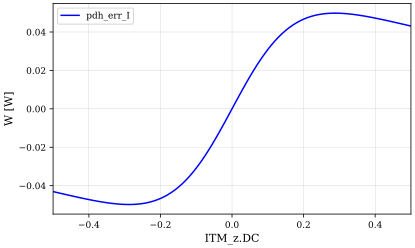

In [49]:
sol = model.run('xaxis(ITM_z.DC, lin, -0.5, 0.5, 100, relative=true)')
sol.plot('pdh_err_I')
plt.show()

## Task 1: Introducing a defect
We are now prepared to introduce a defect into the system. As a case study, we will apply a tilt to certain optics. The built-in `xbeta` and `ybeta` commands can be utilised to achieve this and introduce a tilt to the desired optic -- e.g. `model.[opticname].xbeta = tilt`.

**Some conventions:** `xbeta` refers to a rotation in the x, z plane, i.e. around the y-axis, `ybeta` referes to a rotation in the  y, z plane.

In [50]:
model.ITM.xbeta = 1e-6 # tilt in rad
model.ITM.ybeta = 1e-6 # tilt in rad

Applying a tilt to the optic alters the optical path experienced by the beam, resulting in the system deviating from the operating point.

**Task:**
To verify this, run a scan of the cavity length around the current tuning of the system.

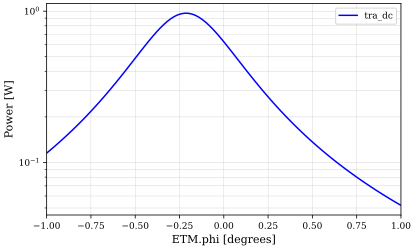

In [51]:
sol = model.run('xaxis(ETM.phi, lin, -1, 1, 100, relative=true)')
sol.plot('tra_dc', logy=True)
plt.show()

The current tuning of the system corresponds to the zero position on the x-axis. Assuming that the operating point is defined as the point of maximum transmitted power, it is evident that the system no longer aligns with this operating point.

## Task 2: Tuning the system to the operating point
Below is an example of how to use the `Maximize` action to fine-tune the system and achieve the point where the transmitted power reaches its maximum.

The Maximize action provides a simplified interface that enables the maximization of the detector's output during simulation by optimizing a specific target parameter -- e.g. `Maximize(detector, [parameter])`.

In [52]:
model.run(fac.Maximize('tra_dc', 'ITM_z.DC'))

<OptimizeSolution of series/maximize @ 0x7fc8522b5a00 children=0>

**Task:** Repeat a scan of the cavity length around the current tuning of the system

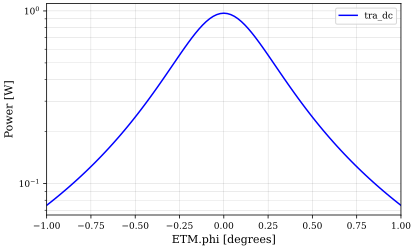

In [53]:
sol = model.run('xaxis(ETM.phi, lin, -1, 1, 100, relative=true)')
sol.plot('tra_dc', logy=True)
plt.show()

## Task 3: operating point VS the zero-crossing point of the error signal
What has just been shown above can be used to gradually introduce a defect and compute the deviation between the operating point and the point where the error signal reaches zero.

The **task** is to use an `xaxis` command to the angle of the input test mass `ETM` 
from `0 rad` a to `5e-6 rad` in the `x,z` plane. You will need to use a `post_step` command in order to maximize the transmitted power from the cavity. This will keep the model at the targeted operating point after each step. Then plot the error signal from `pdh_err` readout.

In [61]:
sol = model.run(
    fac.Xaxis(
        model.ETM.xbeta,
        'lin',
        start = 0,
        stop = 5e-6,
        steps = 10,
        pre_step = fac.Maximize('tra_dc', 'ITM_z.DC', tol=1e-20)
    )
)

Plot now the error signal.

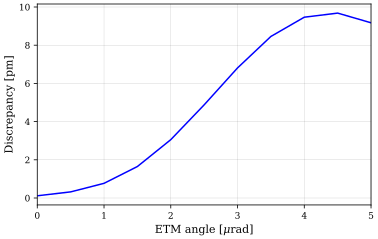

In [62]:
y = sol['pdh_err_I'] # pdh error signal
y /= pdh_gain  # to scale from W to m
y /= 1e-12 # to scale from m to pm

fig = plt.figure()
plt.plot(sol.x1/1e-6, y)
plt.xlabel(r'ETM angle [$\mu$rad]')
plt.ylabel('Discrepancy [pm]')
plt.show()

The plot above shows the PDH error signal (scaled to meters) for each incremental change in the angle of the ETM. Alternatively, this plot can be interpreted as the deviation between the operating point and the point where the error signal reaches zero.

It is important to note that the significant angle changes depicted in the plot are exaggerated to emphasize a point. In reality, such drastic alterations in tilt would be unrealistic. However, this plot serves as a hyperbole to illustrate that, in the presence of substantial defects, the zero-crossing point of the error signal may no longer serve as a reliable reference for the operating point.

**Worth noticing:** the latest features in Finesse3 facilitate the transition from the zero-crossing point of the error signal to a desired operating point. To zero the error signal, the `RunLocks()` action can be executed to run the `lock`. On the other hand, the `Maximize()` action is utilized to optimize the tuning of specific parameters and achieve a desired operating point.